## Day1課題_ロジスティック回帰 : Kickstarter Projects
- 実際のデータを使ってロジスティック回帰を行う

クラウドファンディング愛好家が出したKickstarterというサイトで  
行われたクラウドファンディングの過去のデータを基に成功失敗の分類を予測する。  

- ID：クラウドファンディングの個別ID
- name：クラウドファンディングの名前
- category：詳細なカテゴリー
- main_category：大まかなカテゴリー
- currency ：使用された通貨
- deadline：締め切り日時
- goal：目標調達資金額
- launched：開始した日時
- pledged：集まった資金（運用後は後から分かる変数）
- state：プロジェクトの状態(成功、失敗、キャンセルなど)＝＞教師ありデータ
- backer：集まった支援者（運用後は後から分かる変数）
- country：プロジェクトが開かれた国
- usd pledged： 集まった資金の米ドル換算（運用後は後から分かる変数）

目的変数を「state」にして、説明変数をその他全てとして検討する。

In [3]:
#import
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
# 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix 

from sklearn.preprocessing import StandardScaler #preprocessing：前処理  StandardScaler：標準化
from sklearn.model_selection import train_test_split #データを訓練データとテストデータに分割する
from sklearn.linear_model import SGDClassifier #クラス分類をする

from sklearn import preprocessing

from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## 各関数を定義
### データ検討した結果を定義 => 検討内容は、ノートの後半

In [4]:
#データの読み込みと基本データ修正
def DataLoadAndBasicProcessing():
    #データ読み取り
    df = pd.read_csv("./ks-projects-201801.csv")

    #成功と失敗のデータのみにする
    df = df[(df['state']=='successful')|(df['state']=='failed')]

    #successfulは１に、それ以外は、０に変換
    map_state_info = {'successful':1,'failed':0,'canceled':0,'suspended':0,'undefined':0,'live':0}
    df['state_num'] = df['state'].map(map_state_info)

    # goalのle8に固まっているデータを削除
    df = df[(df['goal']<99000000)]
    
    return df

In [5]:
#期間（日数）のカラムを作成して、作成元カラムを削除
def makePeriod(df):
    #期間取得
    df['deadline'] = pd.to_datetime(df['deadline'], errors='coerce')
    df['launched'] = pd.to_datetime(df['launched'], errors='coerce')
    #df_kickstarter.head(10)

    #期間をperiod列として追加
    df['period'] = (df['deadline'] - df['launched']).dt.days
    #df_kickstarter.head(10)

    # 長い期間は外れ値として、行削除
    df = df[(df['period']<2000)]
    #periodのバンド化を試す
    df['period'] = pd.cut(df["period"],[0, 20, 40, 60, 80, 100, 20000],labels=range(6),right=False)
    
    #不要な列を削除
    drop_colums = ['deadline','launched']
    df = df.drop(drop_colums, axis = 1)

    return df

In [6]:
#ダミー変数加工
#
def ExecuteDummyValuse(df):
    
    df_dummy = pd.get_dummies(df['main_category'])
    df = pd.concat([df,df_dummy],axis=1)
    #df_dummy = pd.get_dummies(df['currency'])
    #df = pd.concat([df_kickstarter,df_dummy],axis=1)  #t
    df_dummy = pd.get_dummies(df['country'])
    df = pd.concat([df,df_dummy],axis=1)
    
    #別データに変更したもの及び類似データを除去
    drop_colums = ['country','currency','category','main_category']
    df = df.drop(drop_colums, axis = 1)

    ##国通貨に相関関係があるため、通貨を削除
    #df = df.drop(drop_colums_currency, axis = 1)
    
    return df

In [7]:
#不要なデータを削除
def DropColums(df):
    
    #不要な列を削除
    drop_colums = ['ID','name','pledged','backers','usd pledged','usd_pledged_real','usd_goal_real']
    df = df.drop(drop_colums, axis = 1)

    #別データに変更したもの
    drop_colums = ['state']
    df = df.drop(drop_colums, axis = 1)

    return df

In [43]:
# ロジスティック回帰の学習及び正答率計算及び混同行列表示の関数
def LogisticRegressionCal(X_train, y_train, X_test, y_test, clf, stdscFlg):

    #標準化:stdscFlg = 1 => 標準化する
    if stdscFlg == 1:
        #stdsc = StandardScaler()
        #X_train = stdsc.fit_transform(X_train) #訓練データの標準化
        #X_test = stdsc.transform(X_test) #テストデータの標準化
        
        #外れ値ありとして標準化
        rscaler = preprocessing.RobustScaler(quantile_range=(25., 75.))        
        X_train = rscaler.fit_transform(X_train) #訓練データの標準化
        X_test = rscaler.transform(X_test) #テストデータの標準化
    
    #学習
    clf.fit(X_train, y_train)

    # 重みを取得して表示
    w0 = clf.intercept_[0]
    print('・重みを取得して表示')
    print(w0,clf.coef_)
    print('')

    # ラベルを予測
    y_pred = clf.predict(X_test)

    # 正答率を計算
    accuracy =  accuracy_score(y_test, y_pred)
    print('・正答率を計算')
    print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

    # Precision, Recall, F1-scoreを計算
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

    # カテゴリ「成功・失敗」に関するPrecision, Recall, F1-scoreを表示
    print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
    print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
    print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))
    print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred)))
    print('')

    # 予測値と正解のクロス集計（混同行列）
    conf_mat = confusion_matrix(y_test, y_pred)
    conf_mat = pd.DataFrame(conf_mat, 
                            index=['正解 = 失敗', '正解 = 成功'], 
                            columns=['予測 = 失敗', '予測 = 成功'])
    print('・予測値と正解のクロス集計（混同行列）')
    print(conf_mat)
    
    #clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
    #LogisticRegressionCal(X, y, X, y, clf)

In [56]:
#クロスバリデーション関数
def evaluate_cross_validation(clf, X, y, n_split):
    #cv = KFold(n_splits=n_split, shuffle=True, random_state=1234)
    #scores = cross_val_score(clf, X, y, cv=cv)
    #print(scores)
    #print ("Mean score: {} (+/-{})".format( np.mean (scores), sem(scores)))
    
    #n_split = 5 # グループ数を設定（今回は5分割）
    
    cross_valid_accuracy = 0
    cross_valid_precision = 0
    cross_valid_recall = 0
    cross_valid_f1_score = 0
    split_num = 1

    # テスト役を交代させながら学習と評価を繰り返す
    for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx] #学習用データ
        X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

        # 学習用データを使ってモデルを学習：モデルをn_splitだけ作成
        clf.fit(X_train, y_train)

        # テストデータに対する予測を実行
        y_pred = clf.predict(X_test)
            
        # 正答率を計算
        accuracy =  accuracy_score(y_test, y_pred)
        print('KFold:',split_num)
        print('・正答率を計算')
        print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

        # Precision, Recall, F1-scoreを計算
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

        # カテゴリ「成功・失敗」に関するPrecision, Recall, F1-scoreを表示
        print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
        print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
        print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))
        print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred)))
        print('')

        # 予測値と正解のクロス集計（混同行列）
        conf_mat = confusion_matrix(y_test, y_pred)
        conf_mat = pd.DataFrame(conf_mat, 
                                index=['正解 = 失敗', '正解 = 成功'], 
                                columns=['予測 = 失敗', '予測 = 成功'])
        print('・予測値と正解のクロス集計（混同行列）')
        print(conf_mat)
        print('--------------------------------------------------------------')
    
        cross_valid_accuracy += accuracy
        cross_valid_precision += precision[1]
        cross_valid_recall += recall[1]
        cross_valid_f1_score += f1_score[1]
        split_num += 1

        
    # それぞれの平均値を最終的な各評価値とする
    accuracy = cross_valid_accuracy / n_split
    final_precision = cross_valid_precision / n_split
    final_recall = cross_valid_recall / n_split
    final_f1_score = cross_valid_f1_score / n_split
    #print("Cross Validation MAE = %s"%round(final_mae, 3))
    
    print('--result---------------------------------')
    print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
    print('Cross Validation 適合率（Precision） = {:.3f}%'.format(100 * final_precision))
    print('Cross Validation 再現率（Recall） = {:.3f}%'.format(100 * final_recall))
    print('Cross Validation F1値（F1-score） = {:.3f}%'.format(100 * final_f1_score))

In [57]:
#データ読み取り
df = pd.read_csv("./ks-projects-201801.csv")

#成功と失敗のデータのみにする
df = df[(df['state']=='successful')|(df['state']=='failed')]

#successfulは１に、それ以外は、０に変換
map_state_info = {'successful':1,'failed':0,'canceled':0,'suspended':0,'undefined':0,'live':0}
df['state_num'] = df['state'].map(map_state_info)

# goalのle8に固まっているデータを削除
df = df[(df['goal']<99000000)]




In [58]:
#読み取りとデータ加工
df = DataLoadAndBasicProcessing()
df = makePeriod(df)
df = ExecuteDummyValuse(df)
df = DropColums(df)

In [59]:
#ロジスティック回帰：goalのみで検討
y = df["state_num"].values
X = df[["goal"]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

print(len(X_train))
print(len(X_test))

232151
99494


In [60]:
#ロジスティック回帰：goalのみで検討
print('---関数の動作検証:対数なしと標準化なし----------------------------------')
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
LogisticRegressionCal(X_train, y_train, X_test, y_test, clf, 0)

print('')
print('---関数の動作検証:対数なしと標準化あり----------------------------------')
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
LogisticRegressionCal(X_train, y_train, X_test, y_test, clf, 1)

print('--- CrossValidation----------------------------------')
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
evaluate_cross_validation(clf, X_train, y_train, 5)

---関数の動作検証:対数なしと標準化なし----------------------------------
・重みを取得して表示
22773.1728979531 [[-39.28906647]]

・正答率を計算
正答率（Accuracy） = 60.924%
適合率（Precision） = 56.137%
再現率（Recall） = 12.874%
F1値（F1-score） = 20.944%
対数尤度 = -13.496

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    55466     4024
正解 = 成功    34854     5150

---関数の動作検証:対数なしと標準化あり----------------------------------
・重みを取得して表示
-0.23178037112818112 [[-0.21049634]]

・正答率を計算
正答率（Accuracy） = 59.793%
適合率（Precision） = 0.000%
再現率（Recall） = 0.000%
F1値（F1-score） = 0.000%
対数尤度 = -13.887

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    59490        0
正解 = 成功    40004        0
--- CrossValidation----------------------------------


/Users/satouyoshihisa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KFold: 1
・正答率を計算
正答率（Accuracy） = 59.172%
適合率（Precision） = 100.000%
再現率（Recall） = 0.005%
F1値（F1-score） = 0.011%
対数尤度 = -14.102

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    27473        0
正解 = 成功    18957        1
--------------------------------------------------------------
KFold: 2
・正答率を計算
正答率（Accuracy） = 59.744%
適合率（Precision） = 86.207%
再現率（Recall） = 0.400%
F1値（F1-score） = 0.796%
対数尤度 = -13.904

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    27664       12
正解 = 成功    18679       75
--------------------------------------------------------------
KFold: 3
・正答率を計算
正答率（Accuracy） = 59.871%
適合率（Precision） = 83.117%
再現率（Recall） = 0.343%
F1値（F1-score） = 0.682%
対数尤度 = -13.860

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    27734       13
正解 = 成功    18619       64
--------------------------------------------------------------
KFold: 4
・正答率を計算
正答率（Accuracy） = 40.327%
適合率（Precision） = 40.327%
再現率（Recall） = 100.000%
F1値（F1-score） = 57.476%
対数尤度 = -20.611

・予測値と正解のク

/Users/satouyoshihisa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KFold: 5
・正答率を計算
正答率（Accuracy） = 59.563%
適合率（Precision） = 67.470%
再現率（Recall） = 0.595%
F1値（F1-score） = 1.179%
対数尤度 = -13.967

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    27543       54
正解 = 成功    18721      112
--------------------------------------------------------------
--result---------------------------------
正答率（Accuracy） = 55.735%
Cross Validation 適合率（Precision） = 75.424%
Cross Validation 再現率（Recall） = 20.268%
Cross Validation F1値（F1-score） = 12.029%


In [30]:
#ロジスティック回帰：goalのみで検討：対数あり
y = df["state_num"].values
X = np.log(df[["goal"]].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(len(X_train))
print(len(X_test))

232151
99494


In [68]:
#ロジスティック回帰：goalのみで検討
print('---関数の動作検証:対数なしと標準化なし----------------------------------')
clf = SGDClassifier(loss='log', penalty='l2', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
LogisticRegressionCal(X_train, y_train, X_test, y_test, clf, 0)

print('')
print('---関数の動作検証:対数なしと標準化あり----------------------------------')
clf = SGDClassifier(loss='log', penalty='l2', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
LogisticRegressionCal(X_train, y_train, X_test, y_test, clf, 1)

print('--- CrossValidation----------------------------------')
clf = SGDClassifier(loss='log', penalty='l2', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
evaluate_cross_validation(clf, X_train, y_train, 5)

---関数の動作検証:対数なしと標準化なし----------------------------------
・重みを取得して表示
20714.14721907238 [[-143773.37255774]]

・正答率を計算
正答率（Accuracy） = 59.793%
適合率（Precision） = 0.000%
再現率（Recall） = 0.000%
F1値（F1-score） = 0.000%
対数尤度 = -13.887

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    59490        0
正解 = 成功    40004        0

---関数の動作検証:対数なしと標準化あり----------------------------------


/Users/satouyoshihisa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


・重みを取得して表示
-0.23179354896875135 [[-0.2104681]]

・正答率を計算
正答率（Accuracy） = 59.793%
適合率（Precision） = 0.000%
再現率（Recall） = 0.000%
F1値（F1-score） = 0.000%
対数尤度 = -13.887

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    59490        0
正解 = 成功    40004        0
--- CrossValidation----------------------------------


/Users/satouyoshihisa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KFold: 1
・正答率を計算
正答率（Accuracy） = 59.172%
適合率（Precision） = 100.000%
再現率（Recall） = 0.005%
F1値（F1-score） = 0.011%
対数尤度 = -14.102

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    27473        0
正解 = 成功    18957        1
--------------------------------------------------------------
KFold: 2
・正答率を計算
正答率（Accuracy） = 59.744%
適合率（Precision） = 86.207%
再現率（Recall） = 0.400%
F1値（F1-score） = 0.796%
対数尤度 = -13.904

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    27664       12
正解 = 成功    18679       75
--------------------------------------------------------------
KFold: 3
・正答率を計算
正答率（Accuracy） = 40.239%
適合率（Precision） = 40.239%
再現率（Recall） = 100.000%
F1値（F1-score） = 57.386%
対数尤度 = -20.641

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗        0    27747
正解 = 成功        0    18683
--------------------------------------------------------------


/Users/satouyoshihisa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KFold: 4
・正答率を計算
正答率（Accuracy） = 59.770%
適合率（Precision） = 80.000%
再現率（Recall） = 0.320%
F1値（F1-score） = 0.638%
対数尤度 = -13.895

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    27691       15
正解 = 成功    18664       60
--------------------------------------------------------------
KFold: 5
・正答率を計算
正答率（Accuracy） = 59.530%
適合率（Precision） = 86.441%
再現率（Recall） = 0.271%
F1値（F1-score） = 0.540%
対数尤度 = -13.978

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    27589        8
正解 = 成功    18782       51
--------------------------------------------------------------
--result---------------------------------
正答率（Accuracy） = 55.691%
Cross Validation 適合率（Precision） = 78.577%
Cross Validation 再現率（Recall） = 20.199%
Cross Validation F1値（F1-score） = 11.874%


In [32]:
#ロジスティック回帰：全項目で検討
y = df["state_num"].values
X = df.drop('state_num', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

print(len(X_train))
print(len(X_test))

232151
99494


In [33]:
#ロジスティック回帰：全項目で検討
print('---関数の動作検証:対数なしと標準化なし----------------------------------')
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
LogisticRegressionCal(X_train, y_train, X_test, y_test, clf, 0)

print('')
print('---関数の動作検証:対数なしと標準化あり----------------------------------')
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
LogisticRegressionCal(X_train, y_train, X_test, y_test, clf, 1)

print('--- CrossValidation----------------------------------')
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
evaluate_cross_validation(clf, X_train, y_train, 5)

---関数の動作検証:対数なしと標準化なし----------------------------------
・重みを取得して表示
21948.45868378983 [[-3.85945266e+04  2.25096053e+04  1.81826787e+03  1.10728416e+03
   1.80041187e+02  4.54341621e+02  1.83183587e+03  7.29077966e+02
   3.92035638e+03  8.53166739e+02  2.23394389e+03  1.05242384e+02
   4.46837638e+03  4.85969814e+02  1.87776798e+03  6.13681825e+02
   1.26910461e+03  6.05401451e+00  2.39657840e+02  1.70340220e+01
   5.93586193e+02  2.15095778e+01  7.92165774e+01  6.34273739e+01
   5.50462142e+01  1.77482940e+02  2.09623611e+03  3.51455352e+01
   2.84415710e+01  2.95405501e+01  6.68952296e-01  3.37615121e+00
   6.45811145e+01  2.00423427e+01  7.32261256e+01  1.12144928e+01
   7.17070286e+01  6.49750734e+01  2.75866640e+01  1.81687022e+04]]

・正答率を計算
正答率（Accuracy） = 59.857%
適合率（Precision） = 84.783%
再現率（Recall） = 0.195%
F1値（F1-score） = 0.389%

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    59476       14
正解 = 成功    39926       78

---関数の動作検証:対数なしと標準化あり------------------------------

/Users/satouyoshihisa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KFold: 4
・正答率を計算
正答率（Accuracy） = 59.813%
適合率（Precision） = 73.050%
再現率（Recall） = 0.550%
F1値（F1-score） = 1.092%

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    27668       38
正解 = 成功    18621      103
--------------------------------------------------------------
KFold: 5
・正答率を計算
正答率（Accuracy） = 60.414%
適合率（Precision） = 56.252%
再現率（Recall） = 10.821%
F1値（F1-score） = 18.151%

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    26012     1585
正解 = 成功    16795     2038
--------------------------------------------------------------
--result---------------------------------
正答率（Accuracy） = 55.947%
Cross Validation 適合率（Precision） = 65.433%
Cross Validation 再現率（Recall） = 23.190%
Cross Validation F1値（F1-score） = 17.023%


In [ ]:
#SVMのグリッドサーチは、応答なしのため、後日再検討
parameters = {'kernel':['linear', 'rbf'], 'C':[1, 5], 'gamma':[0.1, 5]} # ここを編集する
#model = SVC(gamma="scale") # gamma=scaleにすると、gammaが自動で計算される
model = SVC() # gamma=scaleにすると、gammaが自動で計算される
#clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

In [ ]:
# 最適パラメータを用いて識別する
#clf2 = SVC(**clf.best_params_, gamma=clf.best_params_['gamma']) # gamma=scaleにすると、gammaが自動で計算される
clf2.fit(X_train, y_train)
print("識別精度=",clf2.score(X_test, y_test))

In [66]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=10, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

#expl_val = X_train.columns

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index='goal').plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

score= 0.6137169342367683
[1.]


TypeError: Index(...) must be called with a collection of some kind, 'goal' was passed

# 1.データ読み取りと内容確認

In [85]:
#データ読み取り
df_kickstarter = pd.read_csv("./ks-projects-201801.csv")

#Kickstarter Projectsに関する実際のデータ。
display(df_kickstarter.head())
df_kickstarter.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [86]:
#データ概要を取得
df_kickstarter.info()
df_kickstarter.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

## 1-1.項目を検討  
### 運用中のデータから予測するため、成功失敗判定後から分かる変数を説明変数に使用しない。  

ID                  378661 non-null int64  =>削除  
name                378657 non-null object =>削除？  
category            378661 non-null object => 数値化？   
main_category       378661 non-null object => 数値化？  
currency            378661 non-null object => ?  
deadline            378661 non-null object =>期間算定？  
goal                378661 non-null float64 => 通貨統一？、標準化？   
launched            378661 non-null object =>期間算定？    
pledged             378661 non-null float64 => 換算？又は標準化？ （後から分かる変数のため、今回は無視)  
state               378661 non-null object => 目的変数（０、１に置換)  
backers             378661 non-null int64 => （後から分かる変数のため、今回は無視）   
country             378661 non-null object  
usd pledged         374864 non-null float64  
usd_pledged_real    378661 non-null float64  
usd_goal_real       378661 non-null float64  => goalを相関関係があるため、goalを採用して検討


In [87]:
#カラム毎の欠損値の数を表示
df_kickstarter.isnull().sum()
#欠損値処理なし。name及びusd_pledgedは無視。

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [88]:
#sns.pairplot(df_kickstarter)

In [89]:
# 相関係数を確認
df_kickstarter.corr()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
ID,1.000000,0.001679,0.000466,0.000654,-0.000633,-0.000025,0.001854
goal,0.001679,1.000000,0.007358,0.004012,0.005534,0.005104,0.942692
pledged,0.000466,0.007358,1.000000,0.717079,0.857370,0.952843,0.005024
backers,0.000654,0.004012,0.717079,1.000000,0.697426,0.752539,0.004517
usd pledged,-0.000633,0.005534,0.857370,0.697426,1.000000,0.907743,0.006172
usd_pledged_real,-0.000025,0.005104,0.952843,0.752539,0.907743,1.000000,0.005596
usd_goal_real,0.001854,0.942692,0.005024,0.004517,0.006172,0.005596,1.000000


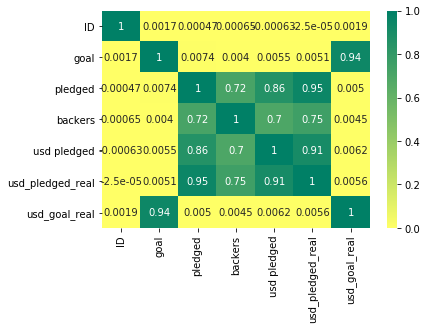

In [91]:
sns.heatmap(df_kickstarter.corr(),cmap="summer_r",annot=True)
#goalとusd_goalは、相関関係があるため、goalを使用して検討

## 2.データ修正：分類対応
## 回帰問題の説明変数として、stateを成功・失敗に分類するため、データを１、０に修正する。

['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


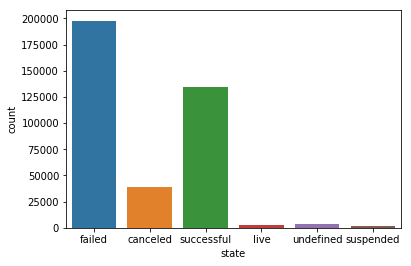

In [92]:
sns.countplot(df_kickstarter.state)
print(df_kickstarter.state.unique())
df_kickstarter.info()

### 今回は、十分にデータ件数があるため、['live' 'undefined' 'suspended']の行を削除（除外）して検討する。  
  又、goalの異常値を除外する。

In [93]:
df_kickstarter = df_kickstarter[(df_kickstarter['state']=='successful')|(df_kickstarter['state']=='failed')|(df_kickstarter['state']=='canceled')]
df_kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370454 entries, 0 to 378660
Data columns (total 15 columns):
ID                  370454 non-null int64
name                370451 non-null object
category            370454 non-null object
main_category       370454 non-null object
currency            370454 non-null object
deadline            370454 non-null object
goal                370454 non-null float64
launched            370454 non-null object
pledged             370454 non-null float64
state               370454 non-null object
backers             370454 non-null int64
country             370454 non-null object
usd pledged         370222 non-null float64
usd_pledged_real    370454 non-null float64
usd_goal_real       370454 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 45.2+ MB


['failed' 'canceled' 'successful']


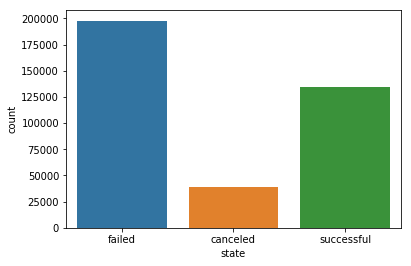

In [94]:
sns.countplot(df_kickstarter.state)
print(df_kickstarter.state.unique())

In [95]:
#successfulは１に、それ以外は、０に変換
map_state_info = {'successful':1,'failed':0,'canceled':0,'suspended':0,'undefined':0,'live':0}
df_kickstarter['state_num'] = df_kickstarter['state'].map(map_state_info)

[0 1]


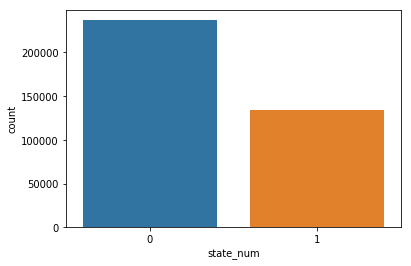

In [96]:
#データ修正結果を確認
sns.countplot(df_kickstarter.state_num)
print(df_kickstarter.state_num.unique())
#print(df_kickstarter.state.unique())

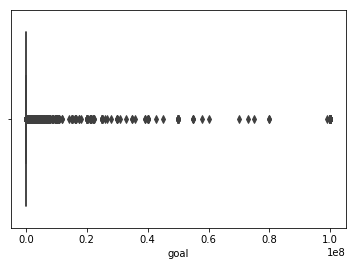

In [97]:
sns.boxplot(df_kickstarter["goal"])
plt.show()

In [98]:
df_kickstarter['goal'].describe()

count    3.704540e+05
mean     4.864199e+04
std      1.159868e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.500000e+03
75%      1.630000e+04
max      1.000000e+08
Name: goal, dtype: float64

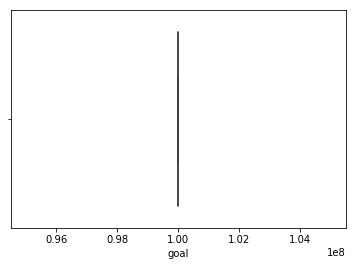

In [99]:
sns.boxplot(df_kickstarter[(df_kickstarter['goal']>99000000)].goal)
plt.show()

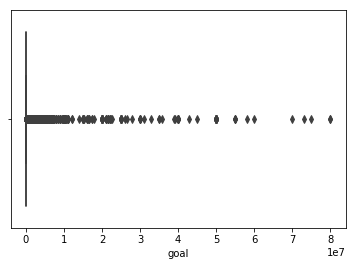

In [100]:
# le8に固まっているデータを削除
df_kickstarter = df_kickstarter[(df_kickstarter['goal']<99000000)]
sns.boxplot(df_kickstarter["goal"])
plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370419 entries, 0 to 378660
Data columns (total 16 columns):
ID                  370419 non-null int64
name                370416 non-null object
category            370419 non-null object
main_category       370419 non-null object
currency            370419 non-null object
deadline            370419 non-null object
goal                370419 non-null float64
launched            370419 non-null object
pledged             370419 non-null float64
state               370419 non-null object
backers             370419 non-null int64
country             370419 non-null object
usd pledged         370187 non-null float64
usd_pledged_real    370419 non-null float64
usd_goal_real       370419 non-null float64
state_num           370419 non-null int64
dtypes: float64(5), int64(3), object(8)
memory usage: 48.0+ MB


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,state_num
count,3.704190e+05,3.704190e+05,3.704190e+05,370419.000000,3.701870e+05,3.704190e+05,3.704190e+05,370419.000000
mean,1.074448e+09,3.920053e+04,9.753935e+03,106.929064,7.077097e+03,9.148441e+03,3.659164e+04,0.361634
std,6.192010e+08,6.339625e+05,9.631993e+04,915.021732,7.882628e+04,9.166838e+04,6.263999e+05,0.480474
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0.000000
25%,5.375718e+08,2.000000e+03,3.200000e+01,2.000000,1.900000e+01,3.248500e+01,2.000000e+03,0.000000
50%,1.075070e+09,5.500000e+03,6.300000e+02,12.000000,4.030000e+02,6.330000e+02,5.500000e+03,0.000000
75%,1.610082e+09,1.620000e+04,4.101000e+03,57.000000,3.065000e+03,4.076050e+03,1.594506e+04,1.000000
max,2.147476e+09,8.000000e+07,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,8.876757e+07,1.000000


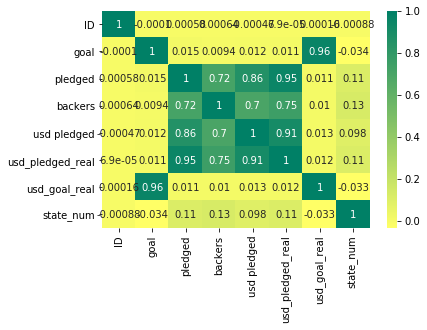

In [104]:
sns.heatmap(df_kickstarter.corr(),cmap="summer_r",annot=True)
#goalとusd_goalは、相関関係があるため、goalを使用して検討
#Kickstarter Projectsに関する実際のデータ。
#display(df_kickstarter.head())

df_kickstarter.info()
df_kickstarter.describe()

## 3.目的変数のみデータ修正して予測してみる。

In [105]:
# ロジスティック回帰
y = df_kickstarter["state_num"].values
X = df_kickstarter[["goal"]].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [106]:
# 重みを取得して表示
w0 = clf.intercept_[0]
print(w0,clf.coef_)

23720.679191292624 [[93.39019961]]


In [107]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「成功・失敗」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率（Accuracy） = 36.163%
適合率（Precision） = 36.163%
再現率（Recall） = 100.000%
F1値（F1-score） = 53.118%


/Users/satouyoshihisa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [108]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,0,236463
正解 = 成功,0,133956


In [162]:
#関数の動作検証
y = df_kickstarter["state_num"].values
X = df_kickstarter[["goal"]].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
LogisticRegressionCal(X, y, X, y, clf, 0)

・重みを取得して表示
22463.958114706253 [[-0.6205571]]

・正答率を計算
正答率（Accuracy） = 45.035%
適合率（Precision） = 39.265%
再現率（Recall） = 95.081%
F1値（F1-score） = 55.579%

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗    39449   197008
正解 = 成功     6589   127367


In [163]:
#関数の動作検証:対数ありと標準化なし
y = df_kickstarter["state_num"].values
X = np.log(df_kickstarter[["goal"]].values)
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
LogisticRegressionCal(X, y, X, y, clf, 0)

・重みを取得して表示
2.0188009854559885 [[-0.29589599]]

・正答率を計算
正答率（Accuracy） = 64.207%
適合率（Precision） = 51.514%
再現率（Recall） = 17.457%
F1値（F1-score） = 26.077%

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗   214447    22010
正解 = 成功   110571    23385


In [117]:
#関数の動作検証:対数あり、標準化あり
y = df_kickstarter["state_num"].values
X = np.log(df_kickstarter[["goal"]].values)
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
LogisticRegressionCal(X, y, X, y, clf, 1)

・重みを取得して表示
-0.5767245985615995 [[-0.54507585]]

・正答率を計算
正答率（Accuracy） = 64.206%
適合率（Precision） = 51.505%
再現率（Recall） = 17.460%
F1値（F1-score） = 26.079%

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗   214441    22022
正解 = 成功   110567    23389


In [118]:
clf = SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
LogisticRegressionCal(X, y, X, y, clf, 0)

・重みを取得して表示
1.973319438177375 [[-0.26094795]]

・正答率を計算
正答率（Accuracy） = 63.541%
適合率（Precision） = 49.343%
再現率（Recall） = 30.744%
F1値（F1-score） = 37.884%

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗   194183    42280
正解 = 成功    92772    41184


## 4.期間を説明変数として追加してみる。

In [120]:
#期間取得
df_kickstarter['deadline'] = pd.to_datetime(df_kickstarter['deadline'], errors='coerce')
df_kickstarter['launched'] = pd.to_datetime(df_kickstarter['launched'], errors='coerce')
#df_kickstarter.head(10)

In [121]:
#期間をperiod列として追加
df_kickstarter['period'] = (df_kickstarter['deadline'] - df_kickstarter['launched']).dt.days
#df_kickstarter.head(10)

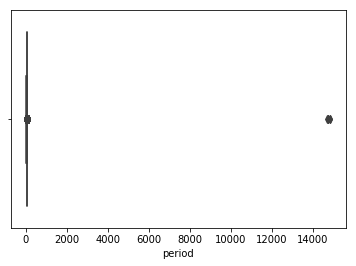

In [122]:
sns.boxplot(df_kickstarter["period"])
plt.show()

In [123]:
# 長い期間は外れ値として、行削除
df_kickstarter = df_kickstarter[(df_kickstarter['period']<2000)]
#periodのバンド化を試す
df_kickstarter['period'] = pd.cut(df_kickstarter["period"],[0, 20, 40, 60, 80, 100, 20000],labels=range(6),right=False)
df_kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370413 entries, 0 to 378660
Data columns (total 17 columns):
ID                  370413 non-null int64
name                370410 non-null object
category            370413 non-null object
main_category       370413 non-null object
currency            370413 non-null object
deadline            370413 non-null datetime64[ns]
goal                370413 non-null float64
launched            370413 non-null datetime64[ns]
pledged             370413 non-null float64
state               370413 non-null object
backers             370413 non-null int64
country             370413 non-null object
usd pledged         370181 non-null float64
usd_pledged_real    370413 non-null float64
usd_goal_real       370413 non-null float64
state_num           370413 non-null int64
period              370413 non-null category
dtypes: category(1), datetime64[ns](2), float64(5), int64(3), object(6)
memory usage: 48.4+ MB


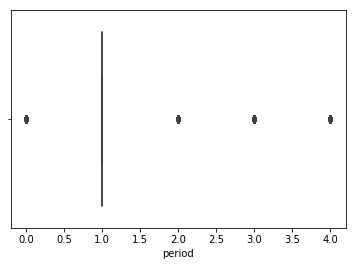

In [124]:
sns.boxplot(df_kickstarter["period"])
plt.show()

[2, 1, 0, 3, 4]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]


ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         232
usd_pledged_real      0
usd_goal_real         0
state_num             0
period                0
dtype: int64

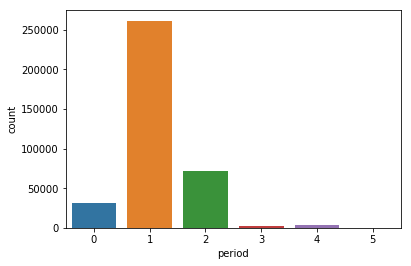

In [125]:
print(df_kickstarter.period.unique())
sns.countplot(df_kickstarter.period)
df_kickstarter.isnull().sum()

In [139]:
# ロジスティック回帰
y = df_kickstarter['state_num'].values
X = df_kickstarter[['goal','period']].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
print(clf.fit(X, y))

# 重みを取得して表示
w0 = clf.intercept_[0]
print(w0,clf.coef_)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
21119.70350527906 [[-1.60108245e+01  2.17081991e+04]]


In [140]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「成功・失敗」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

正答率（Accuracy） = 62.057%
適合率（Precision） = 47.171%
再現率（Recall） = 41.015%
F1値（F1-score） = 43.878%


,予測 = 失敗,予測 = 成功
正解 = 失敗,174924,61533
正解 = 成功,79014,54942


In [147]:
#関数の動作検証:対数あり、標準化あり
y = df_kickstarter['state_num'].values
df_kickstarter['goal_log'] = np.log(df_kickstarter['goal'].values)
X = df_kickstarter[['goal','period']].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
LogisticRegressionCal(X, y, X, y, clf, 0)

・重みを取得して表示
21119.70350527906 [[-1.60108245e+01  2.17081991e+04]]

・正答率を計算
正答率（Accuracy） = 62.057%
適合率（Precision） = 47.171%
再現率（Recall） = 41.015%
F1値（F1-score） = 43.878%

・予測値と正解のクロス集計（混同行列）
         予測 = 失敗  予測 = 成功
正解 = 失敗   174924    61533
正解 = 成功    79014    54942


## 期間をバンド化にすることで性能低下回避？。期間の取り扱いは要検討。

# 5.'country','currency','main_category'をダミー変数として説明変数に追加する。=> countryとcurrencyに相関関係があるため、countryのみを使用

In [56]:
df_kickstarter['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

In [149]:
#削除用currencyを取得
drop_colums_currency = df_kickstarter['currency'].unique()
print(drop_colums_currency)

['GBP' 'USD' 'CAD' 'AUD' 'NOK' 'EUR' 'MXN' 'SEK' 'NZD' 'CHF' 'DKK' 'HKD'
 'SGD' 'JPY']


In [150]:
df_dummy = pd.get_dummies(df_kickstarter['main_category'])
df_kickstarter = pd.concat([df_kickstarter,df_dummy],axis=1)
df_dummy = pd.get_dummies(df_kickstarter['currency'])
df_kickstarter = pd.concat([df_kickstarter,df_dummy],axis=1)
df_dummy = pd.get_dummies(df_kickstarter['country'])
df_kickstarter = pd.concat([df_kickstarter,df_dummy],axis=1)
#df_kickstarter.head(10)

In [151]:
#不要な列を削除
drop_colums = ['ID','name','pledged','backers','usd pledged','usd_pledged_real','usd_goal_real']
df_kickstarter = df_kickstarter.drop(drop_colums, axis = 1)

#別データに変更したもの
drop_colums = ['state','deadline','country','currency','category','main_category','launched']
df_kickstarter = df_kickstarter.drop(drop_colums, axis = 1)

In [59]:
#カラム毎の欠損値の数を表示
df_kickstarter.isnull().sum()

goal            0
state_num       0
period          0
Art             0
Comics          0
Crafts          0
Dance           0
Design          0
Fashion         0
Film & Video    0
Food            0
Games           0
Journalism      0
Music           0
Photography     0
Publishing      0
Technology      0
Theater         0
AUD             0
CAD             0
CHF             0
DKK             0
EUR             0
GBP             0
HKD             0
JPY             0
MXN             0
NOK             0
NZD             0
SEK             0
SGD             0
USD             0
AT              0
AU              0
BE              0
CA              0
CH              0
DE              0
DK              0
ES              0
FR              0
GB              0
HK              0
IE              0
IT              0
JP              0
LU              0
MX              0
N,0"            0
NL              0
NO              0
NZ              0
SE              0
SG              0
US              0
dtype: int

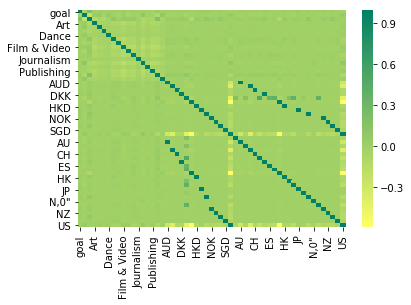

In [152]:
sns.heatmap(df_kickstarter.corr(),cmap="summer_r")

In [154]:
#国通貨に相関関係があるため、通貨を削除
df_kickstarter = df_kickstarter.drop(drop_colums_currency, axis = 1)

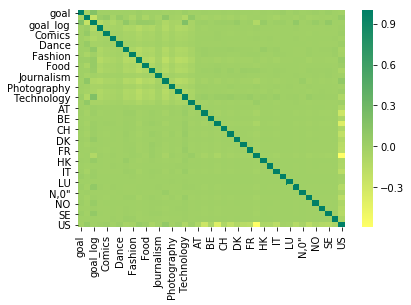

In [155]:
sns.heatmap(df_kickstarter.corr(),cmap="summer_r")

In [156]:
# ロジスティック回帰
y = df_kickstarter["state_num"].values
X = df_kickstarter.drop('state_num', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
print(clf.fit(X, y))

# 重みを取得して表示
w0 = clf.intercept_[0]
print(w0,clf.coef_)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
14361.62783039267 [[-1.25168765e+02  1.46375954e+04  1.20460943e+05  1.09821506e+03
   7.64751263e+02  4.09718493e+00  3.56044302e+02  1.37875976e+03
   3.67257027e+02  2.73755032e+03  5.45115234e+02  1.55780751e+03
   8.37587942e+00  3.07194951e+03  2.34260444e+02  9.58048821e+02
   3.58955844e+02  9.20439674e+02 -1.09074487e+00  1.54484211e+02
   4.18540849e+00  3.47186953e+02  1.51403787e+01  7.22055106e+01
   7.08562422e+01  1.88318593e+01  6.87389853e+01  1.03760787e+03
   2.86503856e+01 -7.09356036e-01 -1.19686486e+01 -6.79235274e-01
   2.71788860e+00  5.54229197e+01  1.35423267e+01  

In [157]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「成功・失敗」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

正答率（Accuracy） = 56.557%
適合率（Precision） = 43.914%
再現率（Recall） = 72.616%
F1値（F1-score） = 54.731%


,予測 = 失敗,予測 = 成功
正解 = 失敗,112222,124235
正解 = 成功,36682,97274


## 6.期間を除外して計算（ダミー変数とgoalを説明変数で予測）

In [158]:
# ロジスティック回帰
y = df_kickstarter["state_num"].values
X = df_kickstarter.drop(['state_num','period'], axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
print(clf.fit(X, y))

# 重みを取得して表示
w0 = clf.intercept_[0]
print(w0,clf.coef_)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
14503.163553169345 [[-1.24984494e+02  1.21614413e+05  1.11265201e+03  7.71818341e+02
   5.73422653e+00  3.57607448e+02  1.39038355e+03  3.76423963e+02
   2.75945839e+03  5.55878850e+02  1.57012056e+03  9.37918858e+00
   3.08725666e+03  2.38845162e+02  9.65188080e+02  3.75876795e+02
   9.26540323e+02 -1.58459538e+00  1.56535049e+02  4.55348934e+00
   3.52232093e+02  1.55507599e+01  7.36882787e+01  7.13764639e+01
   2.02727024e+01  7.01071995e+01  1.04951880e+03  2.84796615e+01
   4.61624151e-01 -1.00878146e+01 -6.11728763e-01  2.77032619e+00
   5.60854525e+01  1.33660137e+01  4.36299950e+01 

In [159]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「成功・失敗」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

正答率（Accuracy） = 56.594%
適合率（Precision） = 43.937%
再現率（Recall） = 72.567%
F1値（F1-score） = 54.734%


,予測 = 失敗,予測 = 成功
正解 = 失敗,112422,124035
正解 = 成功,36748,97208
